# Подготовка

## Цель

Обучить модель нейронной сети верефицировать транзакцию в сети блокчейн Ethereum (бинарная классификация: мошенническая или нет) по имеющемуся и сгенерированному набору признаков о транзакции, отправителе и получателе.

## Описание

Датасет содержит таблицу с транзациями в сети блокчейн Ethereum.

Описание файлов:

* Dataset.csv - транзакции
* fakeAddresses_unique.txt - адреса (не актуально)

Описание полей:

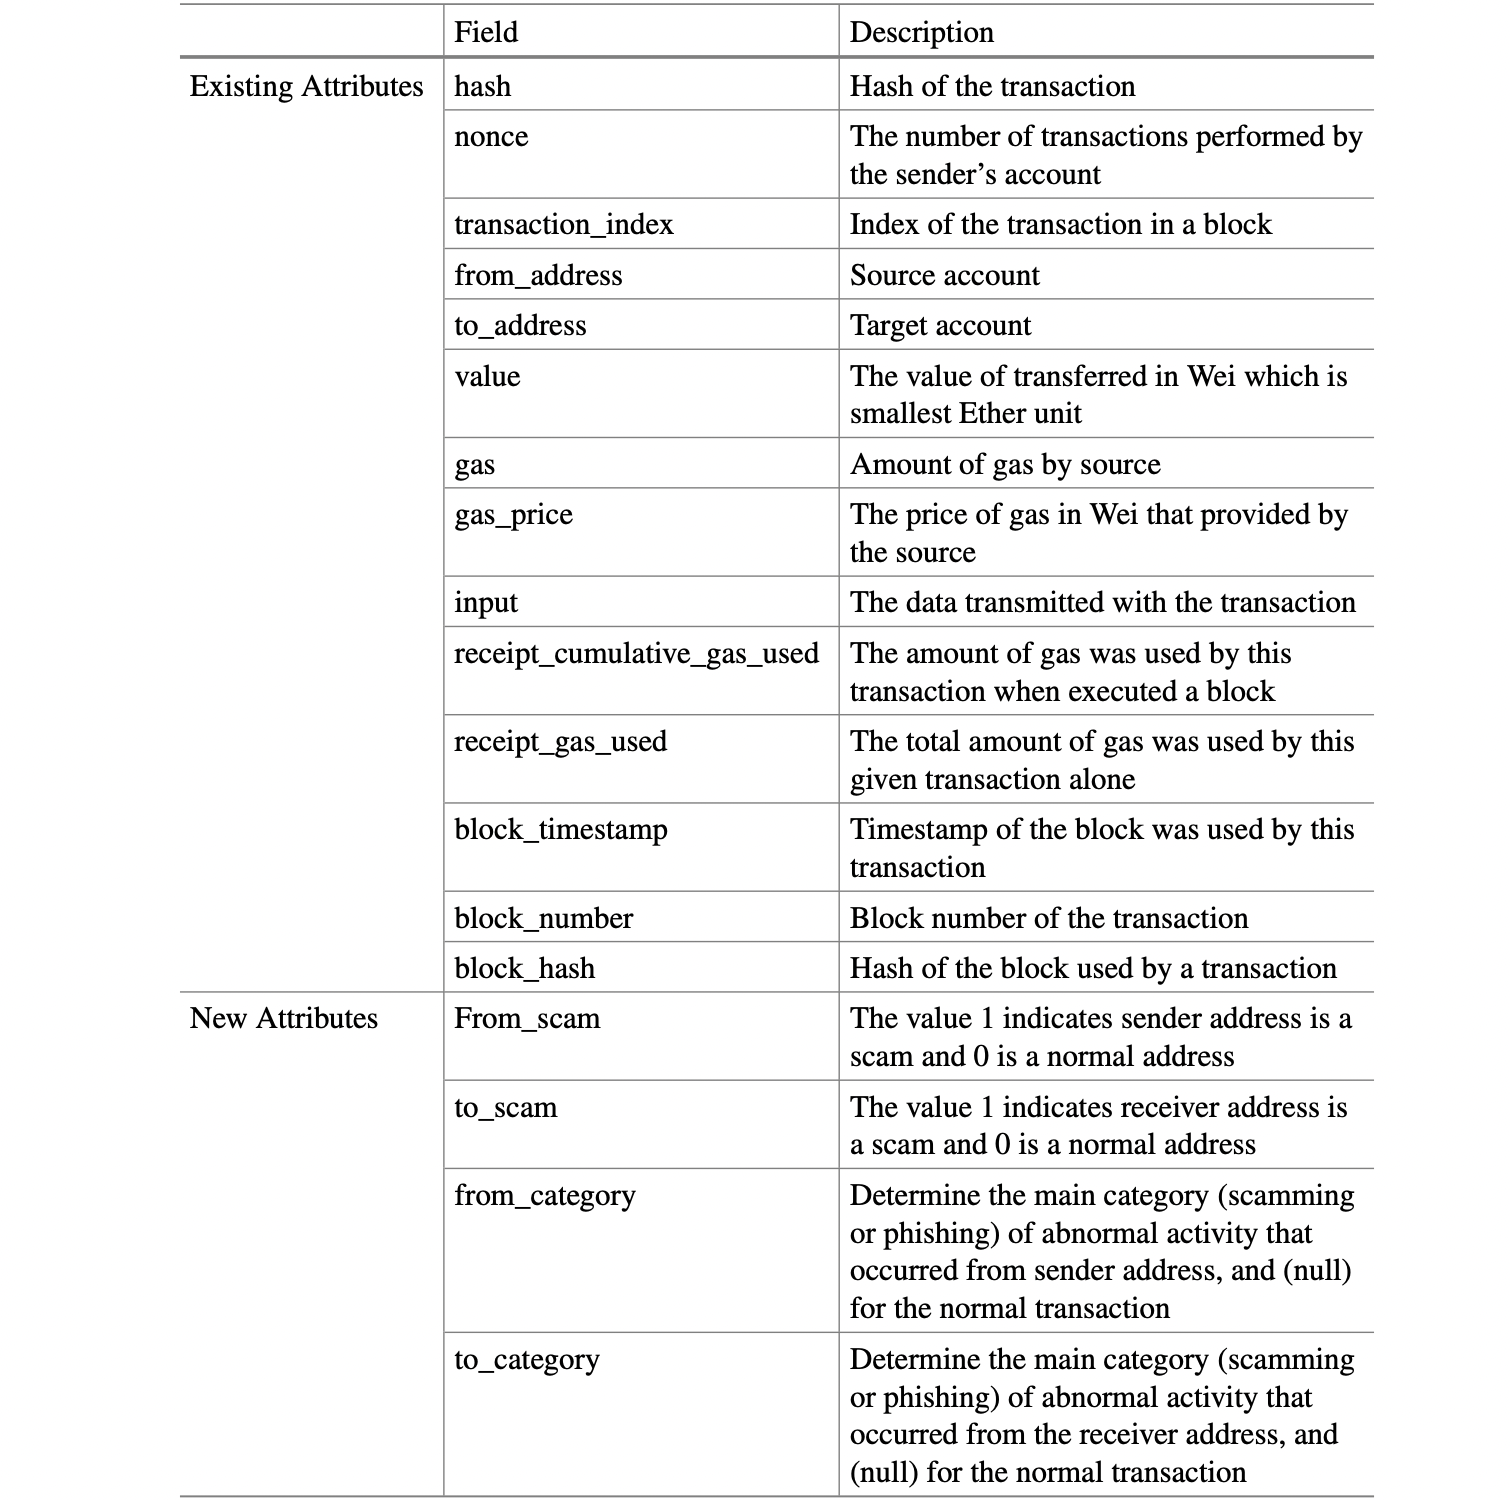

Источник:

https://www.researchgate.net/profile/Salam-Al-Emari/publication/349036616_A_Labeled_Transactions-Based_Dataset_on_the_Ethereum_Network/links/60ed51bd16f9f313007c75d2/A-Labeled-Transactions-Based-Dataset-on-the-Ethereum-Network.pdf?origin=publication_detail

## Загрузка

Установка обновленной библиотеки

In [ ]:
!pip install scipy==1.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.6 MB 7.1 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


Клонируем репозиторий с датасетом

In [ ]:
!git clone https://github.com/salam-ammari/Labeled-Transactions-based-Dataset-of-Ethereum-Network.git

Cloning into 'Labeled-Transactions-based-Dataset-of-Ethereum-Network'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 44 (delta 22), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


Разархивируем архив с датасетом из репозитория

In [ ]:
!unzip '/content/Labeled-Transactions-based-Dataset-of-Ethereum-Network/Dataset.zip' -d '/content'

Archive:  /content/Labeled-Transactions-based-Dataset-of-Ethereum-Network/Dataset.zip
   creating: /content/Dataset/
  inflating: /content/Dataset/Dataset.csv  
  inflating: /content/Dataset/fakeAddresses_unique.txt  


Загружаем датасет в pandas dataframe

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None # отключаем лишние предупреждения

df_ = pd.read_csv('/content/Dataset/Dataset.csv')

## Препроцессинг

Ознакомимся с размером и частью датасета

In [ ]:
df = df_.copy(deep=True) # копируем изначальный датасет, чтобы не портить источник
print('Размерность таблицы датасета:', df.shape)
df.head()

Размерность таблицы датасета: (71250, 18)


,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,block_timestamp,block_number,block_hash,from_scam,to_scam,from_category,to_category
0,0x253ec84729f5c11437f5346830e6bdc9857171b16097...,370394,4,0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,0xd707ac0098599006f0857e8da4c950795645ba01,1.800000e+18,30000,2.205000e+10,0x,129358,21000,2017-10-16 05:26:53 UTC,4370008,0x5e14d30d2155c0cdd65044d7e0f296373f3e92f65ebd...,0,0,NaN,NaN
1,0xfa5f1d7715562adb1e408fdbbbbfc033ae4fadca1e07...,229082,85,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xb8f6e76d34d4877732dfefa6b6a4e2a834a9092b,7.500000e+15,90000,2.060947e+10,0x,5415387,21000,2017-10-16 05:28:49 UTC,4370014,0x900efe010b41b8b6b135db041422fac80b69b96d93c2...,0,0,NaN,NaN
2,0x37928f1d12ee769d0876695aaa815c13d705f8b1e376...,229095,31,0x304cc179719bc5b05418d6f7f6783abe45d83090,0x5ec492652d7b92421680f21169ff6a8dbbc622ab,7.500000e+15,90000,2.060947e+10,0x,1369625,21000,2017-10-16 05:29:19 UTC,4370015,0xfe7d1bc1c6257f92bacb0f8b1266c9894dda99b42e78...,0,0,NaN,NaN
3,0xaad886f331a2fb40495cdf5faa10882852fcd324f064...,229126,78,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xdf01b231b53d8b4cbb1b092a8dc86730cebf4aa9,7.500000e+15,90000,2.060947e+10,0x,2464655,21000,2017-10-16 05:29:43 UTC,4370016,0x1d132e9cd35e9e2cf8350258401b43474772eb1904f1...,0,0,NaN,NaN
4,0x3dbe36fd1a1b01b5e1b343ff78ec1ec189feee5acf46...,229131,83,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xaa4b9693c54029d180134161cc99e98b76cea249,7.500000e+15,90000,2.060947e+10,0x,2569655,21000,2017-10-16 05:29:43 UTC,4370016,0x1d132e9cd35e9e2cf8350258401b43474772eb1904f1...,0,0,NaN,NaN


Для анализа транзакций я выбрал следующие поля:

In [ ]:
df = df_[['nonce', 'transaction_index', 'from_address', 'to_address', 'value', 
         'gas', 'gas_price', 'receipt_cumulative_gas_used', 'receipt_gas_used']]
df['scam'] = df_['from_scam'] | df_['to_scam'] # или получать или отправитель
df.head()

,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,scam
0,370394,4,0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,0xd707ac0098599006f0857e8da4c950795645ba01,1.800000e+18,30000,2.205000e+10,129358,21000,0
1,229082,85,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xb8f6e76d34d4877732dfefa6b6a4e2a834a9092b,7.500000e+15,90000,2.060947e+10,5415387,21000,0
2,229095,31,0x304cc179719bc5b05418d6f7f6783abe45d83090,0x5ec492652d7b92421680f21169ff6a8dbbc622ab,7.500000e+15,90000,2.060947e+10,1369625,21000,0
3,229126,78,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xdf01b231b53d8b4cbb1b092a8dc86730cebf4aa9,7.500000e+15,90000,2.060947e+10,2464655,21000,0
4,229131,83,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xaa4b9693c54029d180134161cc99e98b76cea249,7.500000e+15,90000,2.060947e+10,2569655,21000,0


Конвертируем денежные единицы перевода из Wei в Ethereum

In [ ]:
df['value'] = df['value'] / 1000000000000000000
df['gas_price'] = df['gas_price'] / 1000000000000000000
df.head()

,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,scam
0,370394,4,0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,0xd707ac0098599006f0857e8da4c950795645ba01,1.8000,30000,2.205000e-08,129358,21000,0
1,229082,85,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xb8f6e76d34d4877732dfefa6b6a4e2a834a9092b,0.0075,90000,2.060947e-08,5415387,21000,0
2,229095,31,0x304cc179719bc5b05418d6f7f6783abe45d83090,0x5ec492652d7b92421680f21169ff6a8dbbc622ab,0.0075,90000,2.060947e-08,1369625,21000,0
3,229126,78,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xdf01b231b53d8b4cbb1b092a8dc86730cebf4aa9,0.0075,90000,2.060947e-08,2464655,21000,0
4,229131,83,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xaa4b9693c54029d180134161cc99e98b76cea249,0.0075,90000,2.060947e-08,2569655,21000,0


Закодируем адреса транзакций с помощью label encoder, то есть присвоем сокращенные id. Скэйлинг не потребуется, так как используем RandomForest.

In [ ]:
from sklearn.preprocessing import LabelEncoder
import random
random.seed(1)


full_address = df['from_address'].tolist() + df['to_address'].tolist()
address_label_encoder = LabelEncoder()
address_label_encoder.fit(full_address)

df['from_address'] = address_label_encoder.transform(df['from_address'])
df['to_address'] = address_label_encoder.transform(df['to_address'])
df.head()

,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,scam
0,370394,4,11158,61464,1.8000,30000,2.205000e-08,129358,21000,0
1,229082,85,13989,52970,0.0075,90000,2.060947e-08,5415387,21000,0
2,229095,31,13989,27114,0.0075,90000,2.060947e-08,1369625,21000,0
3,229126,78,13989,63713,0.0075,90000,2.060947e-08,2464655,21000,0
4,229131,83,13989,48759,0.0075,90000,2.060947e-08,2569655,21000,0


# Анализ

## Признаки

Создадим граф networkx из pandas dataframe

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(df, 'from_address', 'to_address', 
                            edge_attr=True, create_using=nx.DiGraph()) # направленный граф из таблички

Добавим специальные признаки, которые обычно используется в задачах предсказания связи.

**Центральность Каца**

Центральность Каца вычисляет относительное влияние узла внутри сети путем измерения количества непосредственных соседей (узлов первой степени), а также всех других узлов в сети, которые подключаются к рассматриваемому узлу через этих непосредственных соседей.

Подробнее:
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.katz_centrality.html

In [ ]:
from networkx.algorithms.centrality import katz_centrality

k = katz_centrality(G, alpha=0.005, beta=1)
mean_k = sum(k.values())/len(k)

**Концентраторы и авторитеты HITS**

Хороший узел-концентратор указывает на большое множество других узлов, а хороший авторитетный узел представляет тот, на который ссылается множество других узлов-концентраторов.

Подробнее: 
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.hits_alg.hits.html

In [ ]:
from networkx.algorithms.link_analysis.hits_alg import hits

h = hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True)

/usr/local/lib/python3.8/dist-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


Добавляем вычесленные признаки к датасету

In [ ]:
df_pl = df.copy(deep=True) # копируем изначальный датасет, чтобы не портить источник
df_pl['katz_from'] = df_pl['from_address'].apply(lambda x: k.get(x, mean_k))
df_pl['katz_to'] = df_pl['to_address'].apply(lambda x: k.get(x, mean_k))
df_pl['hubs_from'] = df_pl['from_address'].apply(lambda x: h[0].get(x, 0)) # концентраторы оценивают значение узла на основе исходящих каналов
df_pl['hubs_to'] = df_pl['to_address'].apply(lambda x: h[0].get(x, 0))
df_pl['authorities_from'] = df_pl['from_address'].apply(lambda x: h[1].get(x, 0)) # авторитеты оценивают значение узла на основе входящих каналов
df_pl['authorities_to'] = df_pl['to_address'].apply(lambda x: h[1].get(x, 0))
df_pl.head()

,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,scam,katz_from,katz_to,hubs_from,hubs_to,authorities_from,authorities_to
0,370394,4,11158,61464,1.8000,30000,2.205000e-08,129358,21000,0,0.003693,0.003693,-4.480432e-16,0.0,-5.485730e-23,-5.132500e-16
1,229082,85,13989,52970,0.0075,90000,2.060947e-08,5415387,21000,0,0.007147,0.003711,-2.809768e-19,0.0,-1.740115e-17,-1.027764e-18
2,229095,31,13989,27114,0.0075,90000,2.060947e-08,1369625,21000,0,0.007147,0.003711,-2.809768e-19,0.0,-1.740115e-17,-1.027764e-18
3,229126,78,13989,63713,0.0075,90000,2.060947e-08,2464655,21000,0,0.007147,0.003711,-2.809768e-19,0.0,-1.740115e-17,-1.027764e-18
4,229131,83,13989,48759,0.0075,90000,2.060947e-08,2569655,21000,0,0.007147,0.003711,-2.809768e-19,0.0,-1.740115e-17,-1.027764e-18


Разделяем датасет для обучения и тестирования

In [ ]:
from sklearn.model_selection import train_test_split

df_pl_train, df_pl_test = train_test_split(df_pl, test_size=0.2)
df_pl_train.shape, df_pl_test.shape

((57000, 16), (14250, 16))

In [ ]:
y_train = df_pl_train.pop('scam')
y_test = df_pl_test.pop('scam')

## Обучение

Подробнее: 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Подробнее: 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.

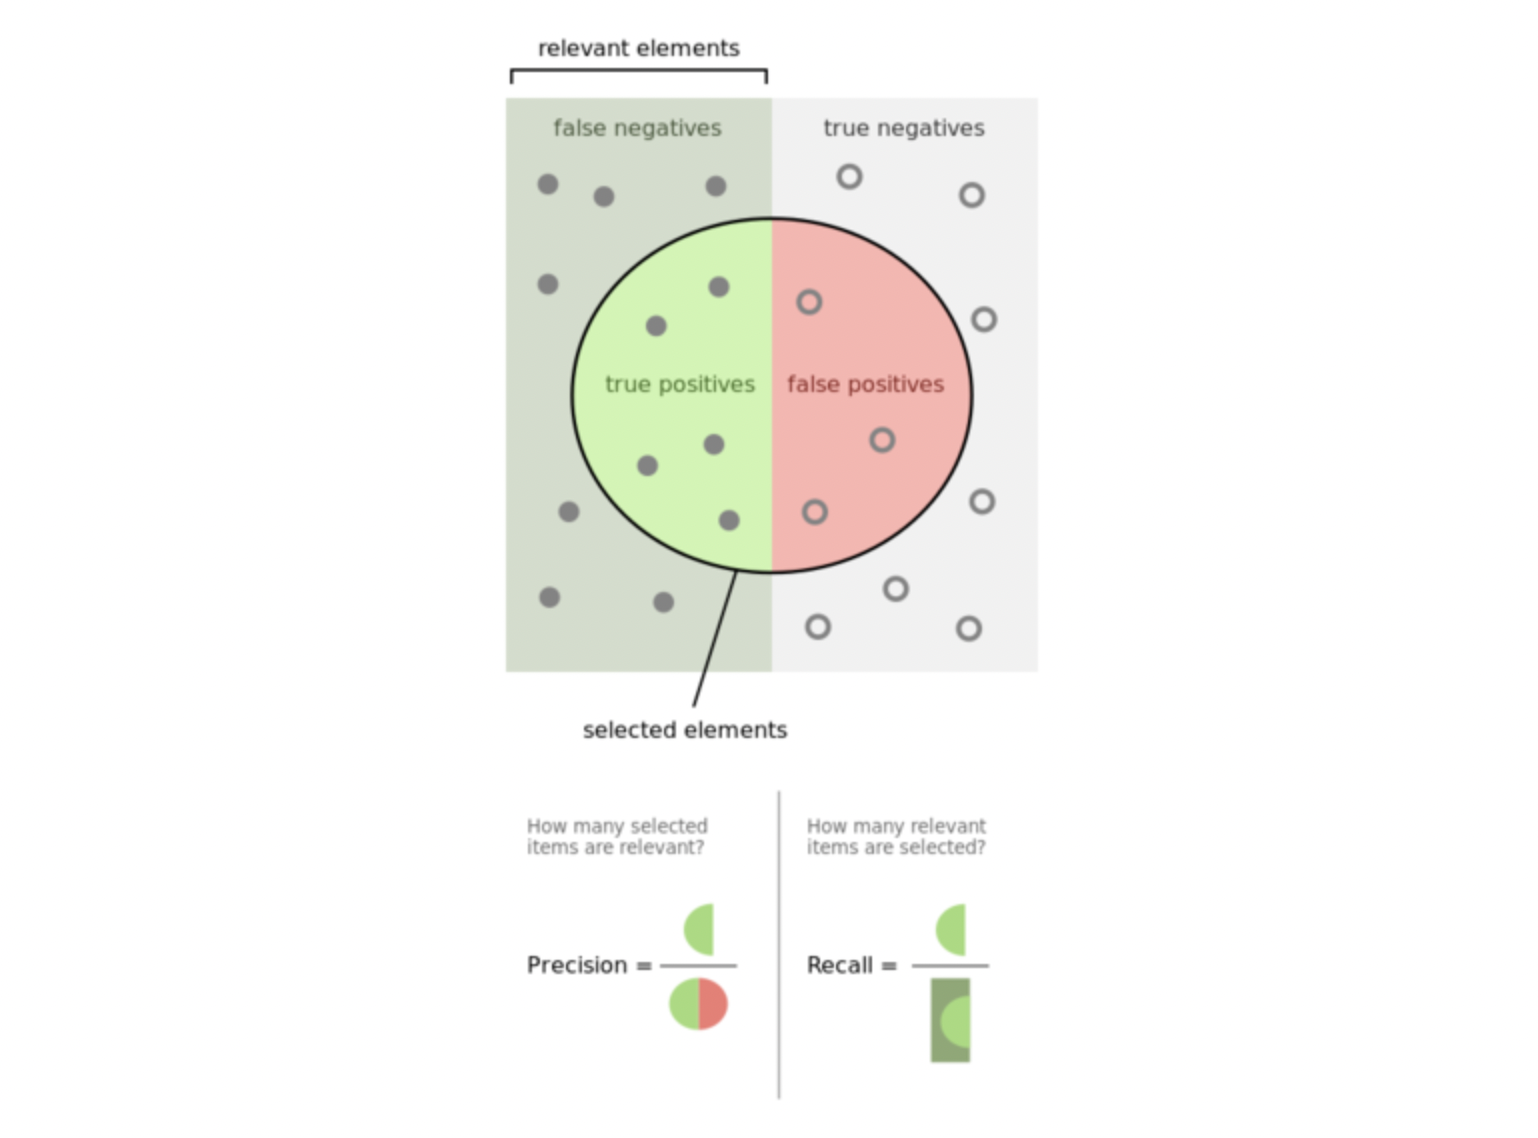

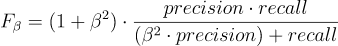

Estimators = 10 | Train F1-score 0.9983835046294741 | Test F1-score 0.9873903997140445
Estimators = 15 | Train F1-score 0.9992275602386433 | Test F1-score 0.9900314576298705
Estimators = 30 | Train F1-score 0.999438299948346 | Test F1-score 0.9885302065748712
Estimators = 60 | Train F1-score 0.9998771788144603 | Test F1-score 0.9894542661449939
Estimators = 120 | Train F1-score 0.9998771788144603 | Test F1-score 0.9887371498728164


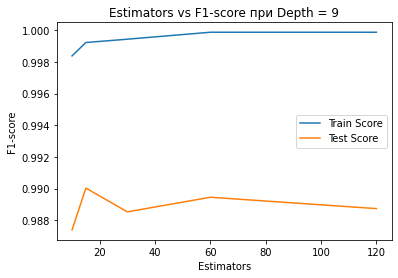

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


# оптимизация гипер параметров (подбираем лучшие гиперпараметры)
estimators = [10,15,30,60,120] # кол-во веток
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(n_estimators=i, max_depth=60)
    clf.fit(df_pl_train, y_train)
    train_sc = f1_score(y_train, clf.predict(df_pl_train), average='weighted')
    test_sc = f1_score(y_test, clf.predict(df_pl_test), average='weighted')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators =', i, '| Train F1-score', train_sc, '| Test F1-score', test_sc)
    
plt.plot(estimators, train_scores, label='Train Score')
plt.plot(estimators, test_scores, label='Test Score')
plt.title('Estimators vs F1-score при Depth = 9')
plt.xlabel('Estimators')
plt.ylabel('F1-score')
plt.legend()
plt.show()

Depth = 9 | Train F1-score 0.953738286080912 | Test F1-score 0.9517588727543599
Depth = 12 | Train F1-score 0.9721384379124756 | Test F1-score 0.967796048717154
Depth = 24 | Train F1-score 0.9987880917555187 | Test F1-score 0.9887355863073019
Depth = 48 | Train F1-score 0.9998596306165188 | Test F1-score 0.9899517828877318
Depth = 96 | Train F1-score 0.9998596306165188 | Test F1-score 0.9895257657243546


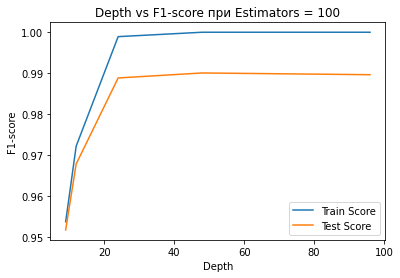

In [ ]:
depths = [9,12,24,48,96] # макс глубина веток
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(n_estimators=120, max_depth=i)
    clf.fit(df_pl_train, y_train)
    train_sc = f1_score(y_train, clf.predict(df_pl_train), average='weighted')
    test_sc = f1_score(y_test, clf.predict(df_pl_test), average='weighted')
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Depth =', i, '| Train F1-score', train_sc, '| Test F1-score', test_sc)

plt.plot(depths, train_scores, label='Train Score')
plt.plot(depths, test_scores, label='Test Score')
plt.title('Depth vs F1-score при Estimators = 100')
plt.xlabel('Depth')
plt.ylabel('F1-score')
plt.legend()
plt.show()

В результате мы получили визуализацию зависимости F1-score от гиперпараметров RandomForestClassifier и хорошую по точности (F1-score > 0.9) модель бинарной классификации

## Адекватность

In [ ]:
from sklearn.metrics import classification_report


clf = RandomForestClassifier(n_estimators=120, max_depth=60)
clf.fit(df_pl_train, y_train)
print(classification_report(y_test, clf.predict(df_pl_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11387
           1       1.00      0.95      0.97      2863

    accuracy                           0.99     14250
   macro avg       0.99      0.98      0.98     14250
weighted avg       0.99      0.99      0.99     14250

